## Neural Networks - Andrej Karpathy -> MultiGrad!

In [2]:
import math

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    epsilon = 1e-9 
    other = other if isinstance(other, Value) else Value(other)
    return self * (other + epsilon)**-1
  
  def __rtruediv__(self, other):
    return self / other

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __rsub__(self, other):
    return self - other

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def sigmoid(self):
    x = self.data
    sig = 1 / (1 + math.exp(-x))

    out = Value(sig, (self, ), 'sigmoid')

    def _backward():
      self.grad += sig * (1 - sig) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  def log(self):
    epsilon = 1e-9
    x = max(self.data, epsilon)
    out = Value(math.log(x), (self, ), 'log')

    def _backward():
      self.grad = (1 / x) * out.grad
    out._backward = _backward
    
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
import random

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x, activation="tanh"):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    if activation == "tanh":
      out = act.tanh()
    else:
      out = act.sigmoid()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x, activation="tanh"):
    outs = [n(x, activation=activation) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x, activation="tanh"):
    for layer in self.layers:
      x = layer(x, activation=activation)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# CS231n Convolutional Neural Networks for Visual Recognition - Stanford (recommended by karpathy for a more intuitive understanding of backpropagation)

### Basics
Challenges of Image Classification: 
- Viewpoint variation
- Illumination 
- Scale Variation
- Deformations
- Occlusion
- Clutter
- Intraclass Variations

Components: 
- Score Function
    - Maps raw data to class scores
- Loss Function
    - Quantifies agreement between the predictions and ground truth.

This is in-turn cast as an optimisation problem in which we minimize the loss function. This is basic NN theory.

### Score function

![scorefunctions](assets/scorefunctions.png "scorefunctions")

- i = 1...N (N samples)
- y = 1...K (K distinct categories)
- D = 3 (RGB) * L * W
- Correct class is expected to have a score higher than incorrect classes. 
- The output matrix is [Kx1] for K labels
- Once we are done training, all we need are the parameters and we no longer need the training data.

##### Bias Trick
- Instead of keeping the bias and weights individually, we can combine bias to the xi matrix as an additional dimension that holds 1.

##### Preprocessing
- Subtraction mean from all the pixels to center data (Bringing it to [-1,1] from [-127,127] ranges)

### Loss Function

#### SVM Loss
![lossfunction1](assets/lossfunctions.png "lossfunction1")

- The loss function wants all correct class scores to be greater than incorrect class scores by "delta", or else we accumulate loss. This is also called hinge loss. There also exists squared hinge loss, which penalises quadratically. This sometimes works better, however, the SVM loss is known to be more standard.


#### Regularisation
"
![lossfunctionwithregulaisation](assets/lossfunctions2.png "lossfunctionwithregulaisation")

One issue with the above loss function is that there can be multiple sets of weights which are optimal with respect to loss, however, we need something that "generalises" on the problem better otherwise we will find ourselves with a model that does not perform well on unseen data.

To mitigate this, we add the regularisation penalty, which is basically the sum of squares of all the weights multiplied by lambda(to be determined through cross validation) to the existing loss.

TLDR: This is an extra loss feature to reduce overfitting.

#### Assignment

In [10]:
import numpy as np

def L_i(x, y, W):
  """
  unvectorized version. Compute the multiclass svm loss for a single example (x,y)
  - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
  - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
  - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
  """
  delta = 1.0 # see notes about delta later in this section
  scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
  correct_class_score = scores[y]
  D = W.shape[0] # number of classes, e.g. 10
  loss_i = 0.0
  for j in range(D): # iterate over all wrong classes
    if j == y:
      # skip for the true class to only loop over incorrect classes
      continue
    # accumulate loss for the i-th example
    loss_i += max(0, scores[j] - correct_class_score + delta)
  return loss_i

def L_i_vectorized(x, y, W):
  """
  A faster half-vectorized implementation. half-vectorized
  refers to the fact that for a single example the implementation contains
  no for loops, but there is still one loop over the examples (outside this function)
  """
  delta = 1.0
  scores = W.dot(x)
  # compute the margins for all classes in one vector operation
  margins = np.maximum(0, scores - scores[y] + delta)
  # on y-th position scores[y] - scores[y] canceled and gave delta. We want
  # to ignore the y-th position and only consider margin on max wrong class
  margins[y] = 0
  loss_i = np.sum(margins)
  return loss_i

def L(X, y, W):
  """
  fully-vectorized implementation :
  - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
  - y is array of integers specifying correct class (e.g. 50,000-D array)
  - W are weights (e.g. 10 x 3073)
  """
  # evaluate loss over all examples in X without using any for loops
  # left as exercise to reader in the assignment
  delta  = 1.0
  scores = W.dot(X)

  margins = np.maximum(0, scores - scores[y, np.arange(X.shape(1))] + delta)
  margins[y, np.arange(X.shape(1))] = 0
  loss_all = np.sum(margins, axis = 0)

  return loss_all


### Softmax Classifier
- Softmax is a generalization of Logistic Regression classifier for multiple classes.
- Cross entropy loss is used to compare probability distributions of the predicted and actual outputs.
- What the softmax function does is it takes model outputs and squashes them into 0-1 probability values.
- The goal of the softmax classifer is to maximize the probability of the correct class. Done by minimizing the negative log likelihood of the correct class. Hence the loss function is simply the negative log of the softmax function.
- This is basically Maximum Likelihood Estimation (MLE).
- Add regularisation to this to penalise large weights and prevent overfitting.
- To prevent numeric stability, it is advised to offset the predictions by the max number of(if the predictions are too large), which simply makes the max prediction 0 so that when you calculate the softmax function, the results are correct but they improve numerical stability as well.

### SVM vs Softmax

![svmvssoftmax](assets/svmvssoftmax.png "svmvssoftmax")

An intuitive difference between the Softmax and SVM is how the classifiers look at the predictions and accumulate loss. Softmax on one hand is never fully satisfied with the predictions it comes up with. The SVM however, is happy if the correct class has a score higher than all incorrect classes by the delta margin. This could be though of both as a bug and a feature depending on the context.

 ### Gradient Descent
We have talked about the loss functions for SVM and Softmax. Now comes the important part, Optimization.

Find the right parameters W, that minimize the loss function.

Its generally easier for gradient descent types of optimisation functions to do well on loss functions that have a convex structure. However. mostly this is not the case. Non linear functions are not convex, which makes reaching global minima challenging. 

The presence of "kinks" in the loss function makes the function non-differentiable at this point because there is no gradient defined. Subgradients are used int his case.

Slope is defined as the instantaneous rate of change of the function at point. The gradient here at any point, points in the direction of "steepest ascent". The derivative quantifies how a small change in the parameter affects the loss function. How much does it affect the loss function. 

Considering, we have the gradients, we simply update the weights in the opposite direction with a given learning rate that slowly goes towards the steepest descent.

In [5]:
def Loss_Function(w):
    return L(X, y, w)

def evaluate_grad(f, x):
    fx = f(x)
    grad = np.zeros(x.shape)

    h = 1e-4
    x_copy = x.copy()
    for i in range(len(x)):
        x_copy[i] = x[i] + h

        fxh = f(x_copy)

        x_copy[i] = x[i]

        grad[i] = (fxh - fx)/h

    return grad

def main():
    W = ...
    gradient = evaluate_grad(Loss_Function, W)

In [6]:
def update():
    learning_rate = 1e-6

    W_new = W - learning_rate * gradient # direction of steepest descent
    loss_new = Loss_function(W_new)

    print(f"for alpha {learning_rate}, the loss is : {loss_new}")


### Backpropagation
In the forward pass step, we calculate the output of the given neuron. Given W = .. and x = .., we calculate W[0] * x[0] + W[1] * x[1] + W[2] which gives us the prediction. Now we calculate the sigmoid of this (activation function that squashes the values between 0 & 1). Now that we have the final value, the next step is the backpropagate. Don't worry about the loss calculation or the weights updation right now.

So what happens is we first calculate the gradient of the sigmoid function applied to the dot product, which gives us the initial gradient. Now we backpropagate and use this gradient to calculate the gradients for the individual variables that affect the predictions, which are the weights and inputs.

ddot = (1 - f) * f -> standard derivative of sigmoid function.
dx = [w[0] * ddot, w[1] * ddot] -> chain rule dL/dx[i] = dL/d(dot) * d(dot)/dx[i]
above applies for dw

In [7]:
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w
# we're done! we have the gradients on the inputs to the circuit

dx

[0.3932238664829637, -0.5898357997244456]

In [8]:
"""
f(x,y) = x + sigma(y) / sigma(x) + (x+y)**2
"""
def sigma(x):
    return 1.0 / 1 + math.exp(-x)

# forward pass
x = 3 
y = -4

sigx = sigma(x)
sigy = sigma(y)

num = x + sigy

xpy = x + y
xpysqr = xpy**2

den = sigx + xpysqr

invden = den**-1
f = num * invden

f

28.587432781397546

In [9]:
dnum = invden
dinvden = num

dden = (-1 / den**2) * invden
dsigx = 1 * dden
dxpysqr = 1 * dden

dxpy = (2 * xpy) * xpysqr
dx = 1 * dxpy
dy = 1 * dxpy 

dx += (1 - sigx) * sigx * dsigx
dx += 1 * dnum
dsigy = 1 * dnum

dy += (1 - sigy) * sigy * dsigy

dx, dy

(-1.5060758067319546, -1482.912912330901)

### Activation functions

- Activation functions take a single number and perform a fixed mathematical operation on it.

#### Sigmoid

![sigmoid](https://cs231n.github.io/assets/nn1/tanh.jpeg "sigmoid")

- Takes a real valued number and "squashes" it into range 0 and 1. In practice, it is fallen out of favor and is rarely ever used. 2 major drawbacks.

    - Saturation: The activation saturatea at either tail of 0 or 1. The gradient at these regions is almost 0. This gradient will be multiplied to the gradient of this gate's output. If this is very small, it effectively kills the gradient and almost no signal will flow through the neuron.
    - Not Zero Centered: Neurons later on would be receiving data is not zero centered. This has implications on the dynamics during gradient descent. If data coming in is always positive, then the gradient on the weights will be all positive or all negative.


#### Tanh
![tanh](https://cs231n.github.io/assets/nn1/tanh.jpeg "tanh")

- Squashes real valued numbers in the range [-1,1]. Activations saturate here as well, but outputs are zero centered. Tanh non-linearity is always preferred over sigmoid.

#### ReLU
![relu](https://cs231n.github.io/assets/nn1/relu.jpeg "relu")

The Rectified Linear Unit has become very popular in the last few years. 

- Known to accelerate the convergence of stochastic gradient descent, compared to other activation functions.
- However, it is possible that ReLU units die during training. This could be because of a large gradient updating weights in a certain way, such that the neuron will never activate. This could cause a certain part of the neural network to simply be dead. With proper learning rate settings, this is rarely the case.

#### Leaky ReLU

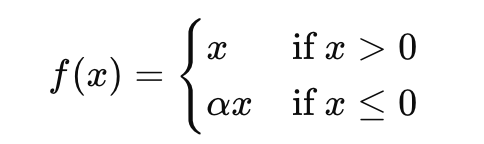

Where:
- x is the input to the activation function.
- α is a small constant (typically 0.01) which determines the slope for negative inputs.

Some success has been seen with this function, but it is not known to be consistent.

### Neural Networks

Neurons in graphs.

Modelled as collection of neurons that are connected in an acyclic graph. Cycles are not allowed to prevent forward pass loops. They are organised into distinct layers of neurons. The most common layer type is **fully connected layer** in which neurons between adjacent layers are fully pairwise connected, but neurons within a single layer share no connections. 

Types of layers: Input layer, hidden layers and the output layer.

In a nueron consisting of an input layer with 3 neurons, a hidden layer with 4 neurons and an output layer with 2 neurons, there will be [3x4] + [4x2] = 20 weights and 4+2 = 6 biases, with a total 26 learnable parameters.


#### The dual face of deep neural networks.
![neural nets](https://cs231n.github.io/assets/nn1/layer_sizes.jpeg)

The network with more neurons is able to express more complicated functions. However this is both a blessing and a curse. Simply because the 20 layer NN has obviously fit the noise in the data. This will not generalise well on the test set.

This is not satisfying argument that smaller NNs are preferred. There are many proven ways to prevent overfitting, such as L2 regularization, dropout and input noise. In practice, this is preferable over smaller networks.

Smaller networks are hard to train because they have few local minimas, but these minimas as easy to converge to, and they are bad. If you're trapped in one of such minima, your model is not going to work. On the other hand, if you train a large network, you'll find multiple solutions, but the variance in the loss will be much smaller. In other words, all solutions are about equally good.

TLDR: Regularization strength is preferred to control the overfitting of a NN.

### Data Preprocessing

#### Mean Subtraction
- Most common form of processing.
- Subtraction of meana across every individual feature in the data
- ``` X -= np.mean(X, axis = 0)```

#### Normalization
- Refers to normalization of the data dimensions so that they are of approximately the same scale.
- ```X /= np.std(X, axis = 0)```


These steps are only necessary when you have reason to believe that different input features have different scales, but they should be of approximately equal importance to the learning algorithm. Not compulsory with images because they are already approximately equal and in the same range. 

#### Common pitfall
The preprocessing statistic should always be computed on the training data, and the applied to the test/validation data.

Computing the mean on the entire dataset and then splitting the data into train/val/test splits is a mistake. 

### Weight Initialization

When it comes to initializing weights, its reasonable to assume the approximately half of them would be negative and other half positive. However, setting all the initial weights to 0 would be a great mistake. This is because, if all the neurons produce the same output, then the updates would be identical throughout during backpropagation, which would prevent any source of asymmetry between neurons.

#### The right way to do it
Weights need to be close to zero, but not equal to zero. It is common to initialize them as small random numbers. This is referred to as **symmetry breaking**.

```W = 0.01 * np.random.randn(D, H)```

**But, why "small" random numbers you ask?**

If the weights are too large, outputs can explode and the learning could become unstable. 

**Distribution**

The distribution of outputs from the above weight vector neural network has a variance that grows with the number of inputs. We can normalize this variance to 1 by scaling the weight vector by the square root of the number of inputs.

```W = np.random.randn(n) / sqrt(n)```

This empirically improves the rate of convergence.

### Bias Initialization
- Common to initialize biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights.
- For ReLU non-linearities, however, some people like to use small constant values such as 0.01 for all biases because this ensures that all the units fire in the beginning and therefor propagate some gradient. Not clear if this provides a consistent improvement.


**```W = np.random.randn(n) * sqrt(2/n)``` with ReLU units is the recommended practice.**

### Regularization

#### L2 Regularization
- Implemented by penalizing the squared magnitude of all parameters on the loss function. That is, for every weight w in the network, we add the term **(λw^2)/2**, where **λ** is the regularization strength. It is common to see the factor of 1/2 in front because then the gradient of this term with respect to the parameter **w** is simply **λw** instead of **2λw**.

- Penalises peaky weight vectors and prefers diffuse ones.


#### Dropout
- Effective, simple and recently introduced.
- It is implemented by keeping a neuron active with some proability **p** (a hyperparameter), or setting it to 0 otherwise.

### Gradient Checks

![gradientcorrect](assets/gradienttobeused.png)
![gradientincorrect](assets/gradientdontuse.png)

In practice, the centered one is preferred. We need to keep track of the relative error for comparison between the analytical and numerical gradients.

|fa' - fn'| / max (|fa', fn'|, k)

k is a small constant to prevent division by 0.
This error is analysed as follows:

- relative error > 1e-2 usually means the gradient is probably wrong
- 1e-2 > relative error > 1e-4 should make you feel uncomfortable
- 1e-4 > relative error is usually okay for objectives with kinks. But if there
are no kinks (e.g. use of tanh nonlinearities and softmax), then 1e-4 is too high.
- 1e-7 and less you should be happy.
- Keep in mind that the deeper the network, the higher the relative errors will be. So if you are gradient checking the input data for a 10-layer network, a relative error of 1e-2 might be okay because the errors build up on the way
- Use double precision.
- Be careful about extremely small numbers in analytical grad / numerical grad (1e-10 or smaller). If they are, scale loss function by a constant otherwise, you will come across floating-point [issues](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html)

- Kinks, as discussed earlier could cause a numerical gradient to computer a zero gradient if reached. This should be handled by keeping track of max(x,y). That is, was x or y higher during the forward pass? If so, at least one winner changes when evaluating f(x+h) and then f(x-h), a kink was crossed.
- Use fewer datapoints. This fixes the kink problem, since loss functions that contain kinks, will have fewer kinks with fewer datapoints. Kinks are introduced by using certain activation functions or loss functions.
- Be careful with the step size h. It's not necessarily smaller the better, because when h is much smaller, you run into numerical precision problems. But sometimes, reducing also fixes the problem. Check this [chart](http://en.wikipedia.org/wiki/Numerical_differentiation) for more context.
- Start performing gradient checks after a **burn-in** time because performing in the first iteration could introduce pathological edge cases and mask incorrect implementations. This is because an incorrect implementation could still produce almost the same pattern as a correct one, but will not generalize to a more characteristic mode of operation where some scores are larger than others.
- Check the data loss and regularization loss individually. Because if this term brings in the majority loss, this could mask an incorrect implementation on the loss gradient.


### Sanity Checks